 # 시계열 전처리 및 기본 모델링


# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 데이터 불러오기

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path, usecols = ['date', 'sales'])
data = data.loc[data['date']<= '2014-10-31'].reset_index(drop = True)
data['date'] = pd.to_datetime(data['date'])
data['weekday'] = data['date'].dt.day_name().str.slice(0,3)
data.head()

,date,sales,weekday
0,2013-01-01,45,Tue
1,2013-01-02,53,Wed
2,2013-01-03,65,Thu
3,2013-01-04,66,Fri
4,2013-01-05,97,Sat


* 변수 설명

    * date : 날짜
    * sales : 판매량
    * weekday : 요일

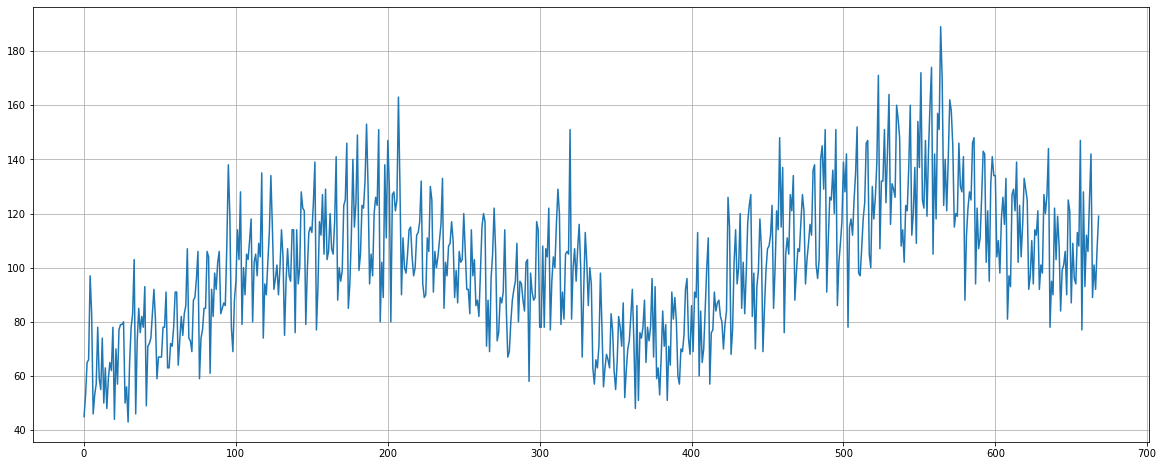

In [3]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

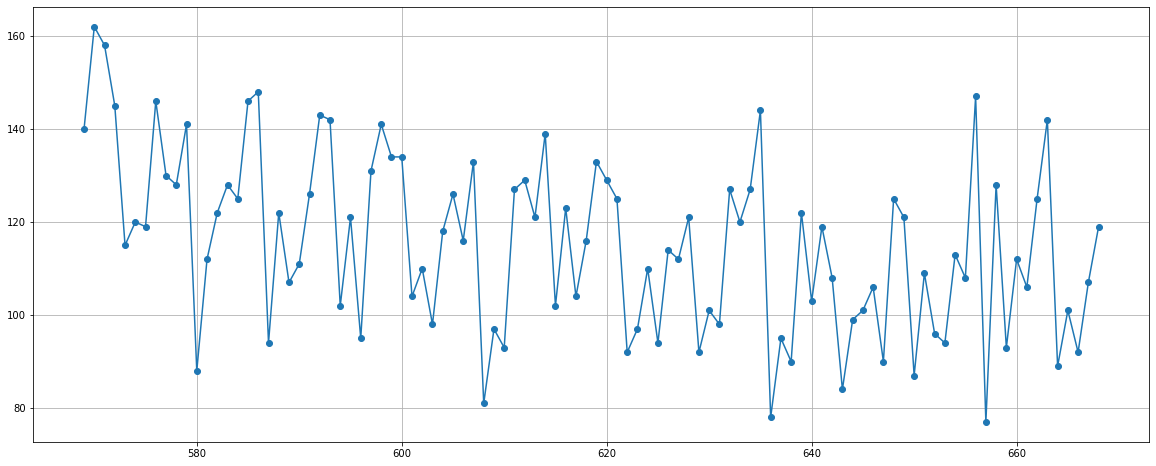

In [4]:
temp = data[-100:]
plt.figure(figsize = (20,8))
plt.plot(temp['sales'], marker ='o')
plt.grid()
plt.show()

# 2.기본 전처리

## (1) y 만들기

* 사전 관찰(look-ahead) : 미래의 어떤 사실을 안다는 뜻
* 사전 관찰 문제 : 
    * 데이터를 통해 실제로 알아야 하는 시점보다 더 일찍 미래에 대한 사실을 알게 되는 문제.  
    * 사전관찰 문제가 있는 채로 모델링을 하게 되면, 놀라운 성능의 모델이 만들어짐. --> 그러나 실제로는 불가능한 상황.

* 그래서 y를 만들때 사전관찰문제가 발생되지 않도록 해야 함.
    * 예제는 1일 후의 수요량을 예측하려고 합니다.

* 1일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [5]:
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,sales,weekday,y
0,2013-01-01,45,Tue,53.0
1,2013-01-02,53,Wed,65.0
2,2013-01-03,65,Thu,66.0
3,2013-01-04,66,Fri,97.0
4,2013-01-05,97,Sat,83.0


,date,sales,weekday,y
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0
668,2014-10-31,119,Fri,NaN


In [6]:
# 제일 마지막 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,sales,weekday,y
663,2014-10-26,142,Sun,89.0
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0


## (2) 가변수화

In [7]:
data = pd.get_dummies(data, columns = ['weekday'], drop_first=False)

## (2) 데이터 분할

### 1) x, y 나누기

In [8]:
target = 'y'

x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

In [9]:
x.head()

,sales,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,45,0,0,0,0,0,1,0
1,53,0,0,0,0,0,0,1
2,65,0,0,0,0,1,0,0
3,66,1,0,0,0,0,0,0
4,97,0,0,1,0,0,0,0


In [10]:
y.head()

0    53.0
1    65.0
2    66.0
3    97.0
4    83.0
Name: y, dtype: float64

### 2) train, val 분할
* 1회 분할 : train_test_split( x, y, test_size= , shuffle = False) 
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기
* k-fold cross validation for Time Seires : TimeSeriesSplit

In [11]:
# 여기서는 1회 분할로 진행합니다.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

In [12]:
x_train.shape, x_val.shape

((638, 8), (30, 8))

# 3.시계열모델링① : ML 기반 모델링

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import * 

## (1) 모델링

In [14]:
model = LinearRegression().fit(x_train, y_train)

## (2) 검증

In [15]:
p1 = model.predict(x_val)

print('RMSE : ', mean_squared_error(y_val, p1, squared = False))
print('MAE  : ', mean_absolute_error(y_val, p1))
print('MAPE : ', mean_absolute_percentage_error(y_val, p1))

RMSE :  16.250732000710066
MAE  :  13.421217429354813
MAPE :  0.12531131106824536


## (3) 결과 시각화

* pred를 시리즈로 바꾸고, 인덱스 맞추기

In [16]:
p1 = pd.Series(p1, index = y_val.index)
p1

638     97.777191
639    124.168672
640    110.697560
641    123.954614
642     70.729089
643     96.039659
644     98.631227
645    106.545315
646    111.415038
647    100.335233
648    128.737227
649     81.091417
650     98.430965
651    106.602248
652    102.559804
653    101.849812
654    118.668582
655    115.186491
656    101.816072
657     90.459944
658    121.747189
659    100.168498
660    116.197651
661    113.088867
662    128.737227
663     97.830562
664    100.025169
665    100.225431
666     99.371396
667    112.212140
dtype: float64

* y_train, y_val(전체), pred 한꺼번에 시각화 

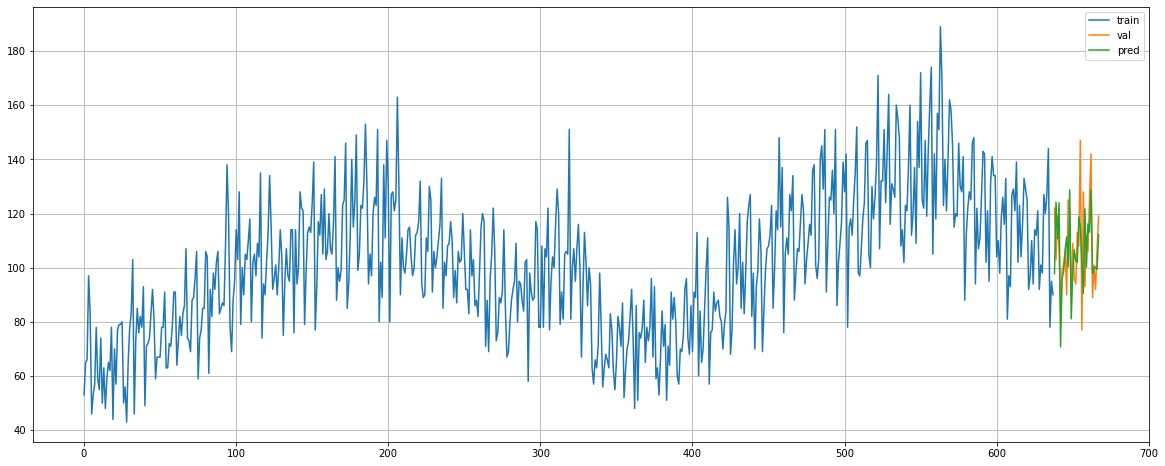

In [17]:
plt.figure(figsize = (20,8))
plt.plot(y_train, label = 'train')
plt.plot(y_val, label = 'val')
plt.plot(p1, label = 'pred')

plt.legend()
plt.grid()
plt.show()

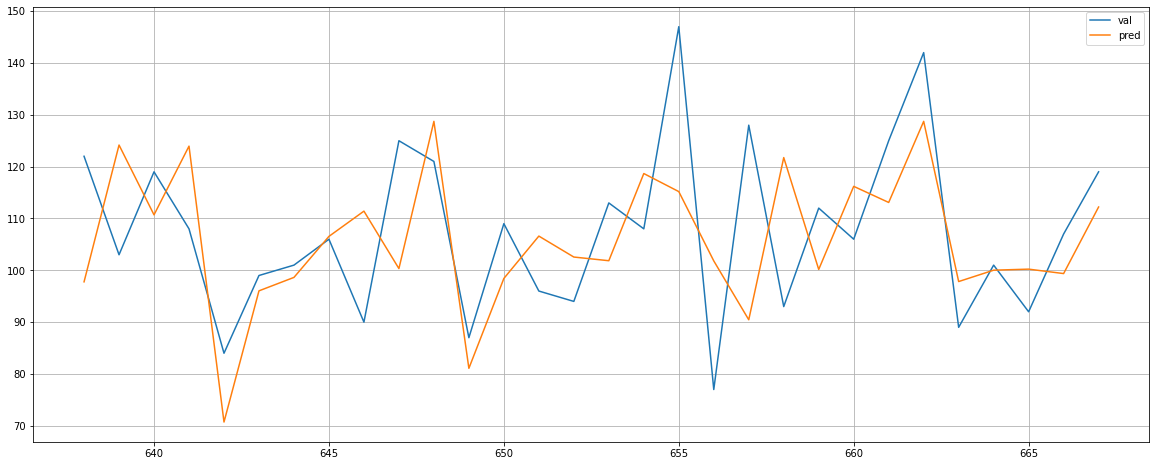

In [18]:
plt.figure(figsize = (20,8))
plt.plot(y_val, label = 'val')
plt.plot(p1, label = 'pred')

plt.legend()
plt.grid()
plt.show()

# 4.시계열모델링② : 전통적 시계열 모델링

## (1) 모델링

In [19]:
m2 = sm.tsa.SARIMAX(y_train, order=(4,1,4)).fit()

## (2) 검증

In [20]:
p2 = m2.forecast(30)

print('RMSE : ', mean_squared_error(y_val, p2, squared = False))
print('MAE  : ', mean_absolute_error(y_val, p2))
print('MAPE : ', mean_absolute_percentage_error(y_val, p2))

RMSE :  15.177312297855542
MAE  :  11.648985016462868
MAPE :  0.11099016704992887


## (3) 결과 시각화

* pred를 시리즈로 바꾸고, 인덱스 맞추기

In [21]:
p2 = pd.Series(p2, index = y_val.index)

* y_train, y_val(전체), pred 한꺼번에 시각화 

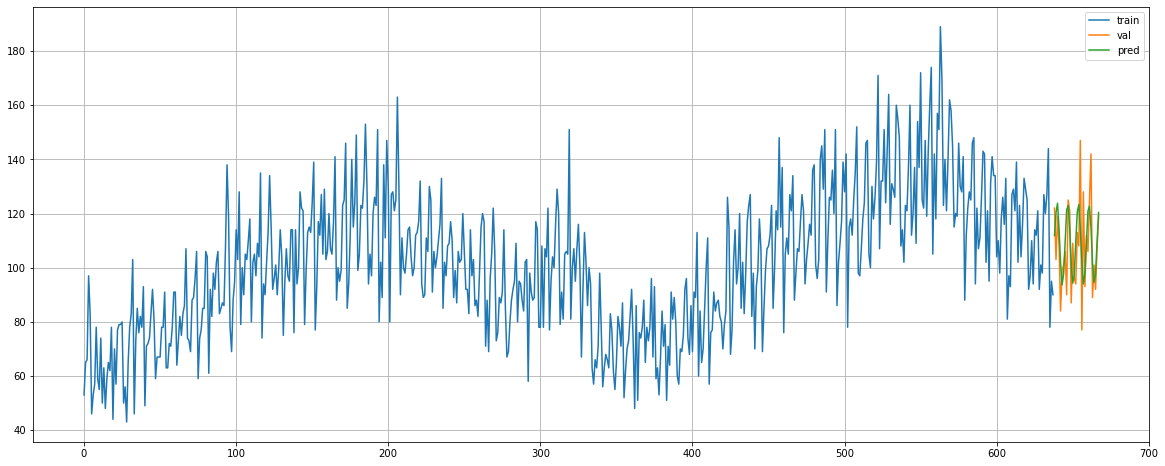

In [22]:
plt.figure(figsize = (20,8))
plt.plot(y_train, label = 'train')
plt.plot(y_val, label = 'val')
plt.plot(p2, label = 'pred')

plt.legend()
plt.grid()
plt.show()

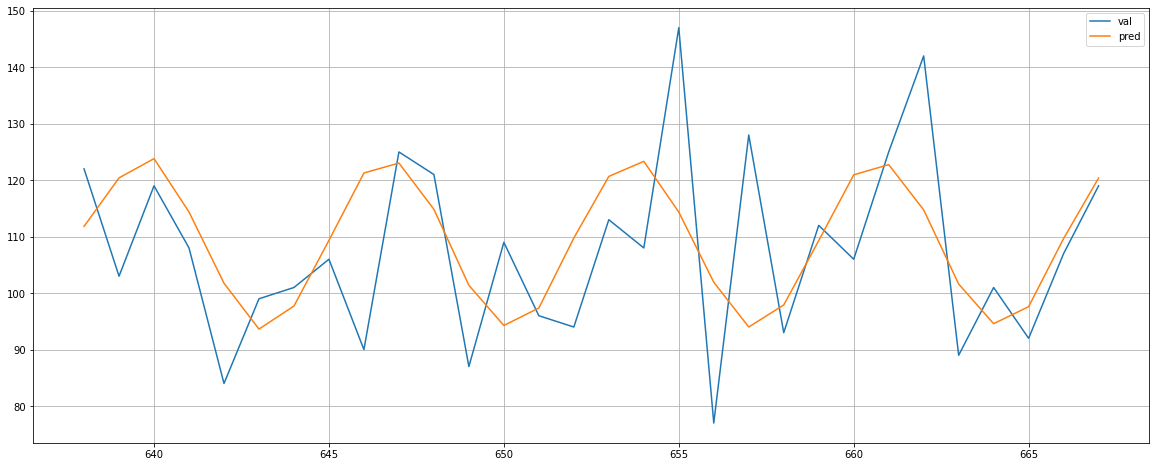

In [23]:
plt.figure(figsize = (20,8))
plt.plot(y_val, label = 'val')
plt.plot(p2, label = 'pred')

plt.legend()
plt.grid()
plt.show()

# 5.평가 : 잔차분석

* 잔차에 대한 우리의 기대 : 화이트 노이즈
    * 자기상관성 없음 : ACF, PACF 그래프
    * 정규분포 : Shapiro-Wilk 검정
    * 평균과 분산이 일정(Stationary) : ADF 검정
* 만약 화이트 노이즈가 아니라면...
    * 더 찾아내야 할 패턴이 있다는 의미.

## (1) ACF, PACF

* 정상 데이터 및 자기상관관계가 없는 데이터라면
* ACF, PACF 그래프에서
    * 첫번째 lag 에서부터 하늘색 범위 안에 값이 위치해야 하고
    * 값의 등락에 대한 어떠한 패턴도 보이지 않아야 합니다.
* 그러나 실제 데이터에서는 그런 결과를 보기 쉽지 않습니다.

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [25]:
residuals = m2.resid

### 1) ACF(자기 상관함수) 

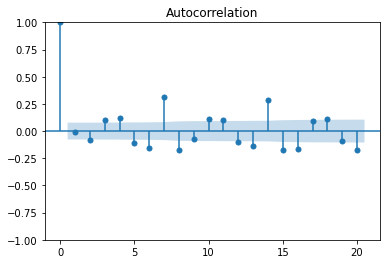

In [26]:
plot_acf(residuals, lags = 20)
plt.show()

In [27]:
res_df = pd.DataFrame({'residuals':residuals})

for i in range(1,21) :
    var = 'lag' + str(i)
    res_df[var] = res_df['residuals'].shift(i)

In [28]:
res_df.head(20)

,residuals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20
0,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12.011859,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.453429,12.011859,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34.280936,7.453429,12.011859,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.245791,34.280936,7.453429,12.011859,53.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-30.070521,10.245791,34.280936,7.453429,12.011859,53.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-11.257767,-30.070521,10.245791,34.280936,7.453429,12.011859,53.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.228044,-11.257767,-30.070521,10.245791,34.280936,7.453429,12.011859,53.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,13.504354,-0.228044,-11.257767,-30.070521,10.245791,34.280936,7.453429,12.011859,53.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-14.752091,13.504354,-0.228044,-11.257767,-30.070521,10.245791,34.280936,7.453429,12.011859,53.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
res_df.corr()

,residuals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20
residuals,1.000000,-0.008667,-0.079737,0.101259,0.120747,-0.108351,-0.162969,0.324901,-0.179062,-0.076578,...,0.101707,-0.106307,-0.140107,0.294109,-0.185535,-0.170636,0.097907,0.119013,-0.090564,-0.177225
lag1,-0.008667,1.000000,-0.009496,-0.082037,0.103580,0.120871,-0.108346,-0.161770,0.325272,-0.178657,...,0.113879,0.100685,-0.107620,-0.142066,0.294831,-0.186291,-0.172551,0.097809,0.118700,-0.090536
lag2,-0.079737,-0.009496,1.000000,-0.011797,-0.080069,0.103716,0.120977,-0.106903,-0.161590,0.326034,...,-0.076947,0.112764,0.099518,-0.109695,-0.141550,0.294344,-0.188422,-0.172785,0.097456,0.118828
lag3,0.101259,-0.082037,-0.011797,1.000000,-0.006276,-0.080076,0.104139,0.125678,-0.106562,-0.160690,...,-0.179052,-0.080406,0.109944,0.095401,-0.108512,-0.143767,0.291327,-0.189359,-0.174333,0.097921
lag4,0.120747,0.103580,-0.080069,-0.006276,1.000000,-0.006513,-0.080426,0.100466,0.125391,-0.108268,...,0.325082,-0.176578,-0.077486,0.114987,0.094184,-0.107112,-0.140106,0.292544,-0.188913,-0.175011
lag5,-0.108351,0.120871,0.103716,-0.080076,-0.006513,1.000000,-0.006518,-0.080727,0.100442,0.125350,...,-0.159355,0.325502,-0.176597,-0.077422,0.114945,0.094283,-0.107101,-0.140092,0.292614,-0.188922
lag6,-0.162969,-0.108346,0.120977,0.104139,-0.080426,-0.006518,1.000000,-0.006634,-0.080747,0.100422,...,-0.108256,-0.159406,0.325882,-0.176791,-0.077479,0.115022,0.094543,-0.107093,-0.140080,0.292611
lag7,0.324901,-0.161770,-0.106903,0.125678,0.100466,-0.080727,-0.006634,1.000000,-0.007124,-0.081910,...,0.124879,-0.106180,-0.157403,0.330358,-0.178231,-0.076327,0.118600,0.094974,-0.106523,-0.140435
lag8,-0.179062,0.325272,-0.161590,-0.106562,0.125391,0.100442,-0.080747,-0.007124,1.000000,-0.007289,...,0.101911,0.125374,-0.105887,-0.157142,0.330256,-0.178077,-0.075932,0.118651,0.095106,-0.106548
lag9,-0.076578,-0.178657,0.326034,-0.160690,-0.108268,0.125350,0.100422,-0.081910,-0.007289,1.000000,...,-0.081994,0.102799,0.126322,-0.104951,-0.157582,0.330839,-0.177315,-0.075853,0.118936,0.095079


### 2) PACF

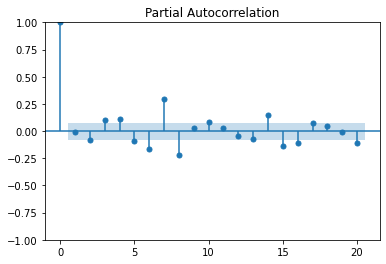

In [30]:
plot_pacf(residuals, lags = 20)
plt.show()

In [ ]:
lags = 20

fig,ax = plt.subplots(1,2, figsize = (15,5))
plot_acf(residuals, lags = lags, ax = ax[0])
plot_pacf(residuals, lags = lags, ax = ax[1])
plt.show()

## (2) 검정
검정 도구를 적용하여 의사결정하는 용도로만 사용합니다.

In [31]:
import scipy.stats as spst
import statsmodels.api as sm

### 1) 정규성 검정 : Shapiro-Wilk 검정

* 귀무가설 : **정규 분포이다.** (p-value > 0.05)
* 대립가설 : 정규분포가 아니다.

In [32]:
spst.shapiro(residuals)[1]

0.006170882377773523

### 2) 정상성 검정 : ADF 검정

* 귀무가설 : 비정상(Non-Stationary) 데이터이다.
* 대립가설 : **정상(Stationary) 데이터**이다.(P-value <= 0.05)

In [33]:
# ADF 테스트
sm.tsa.stattools.adfuller(residuals)[1]

3.270923249041528e-05

# 6.함수로 만들기

## (1) 결과 시각화

In [34]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

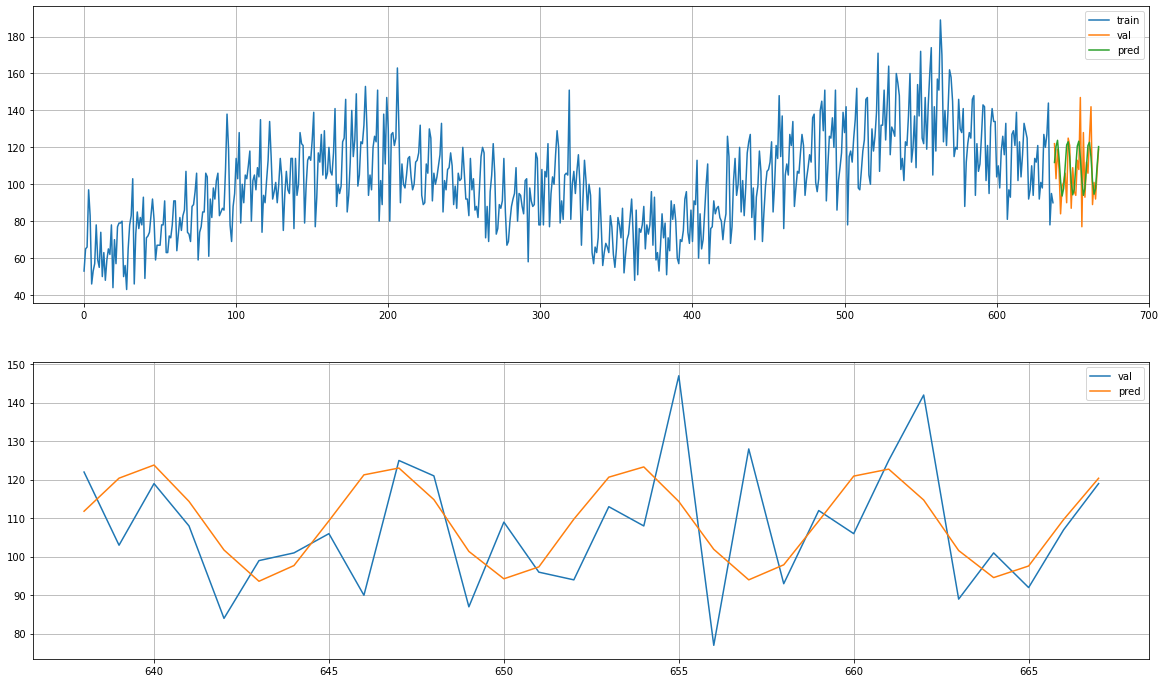

In [35]:
plot_model_result(y_train, y_val, p2)

## (2) 잔차분석

In [36]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

* 정규성 검정(> 0.05) :  0.00617
* 정상성 검정(< 0.05) :  3e-05
* 자기상관성 확인(ACF, PACF)


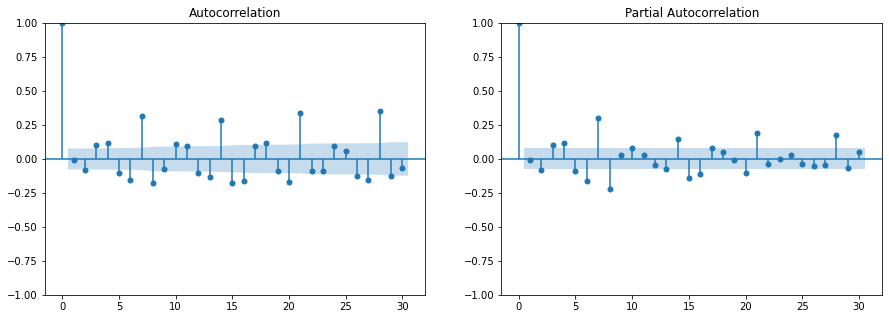

In [37]:
residual_diag(residuals, lags = 30)